# Problema e Objetivo

Há uma falta de conjuntos de dados disponíveis ao público sobre serviços financeiros e, especialmente, no domínio emergente de transações de dinheiro móvel. Conjuntos de dados financeiros são importantes para muitos pesquisadores e, em particular, para nós que realizamos pesquisas no domínio da detecção de fraudes. Parte do problema é a natureza intrinsecamente privada das transações financeiras, que não leva a conjuntos de dados disponíveis publicamente.

Apresentamos um conjunto de dados sintético gerado usando o simulador chamado PaySim como uma abordagem para tal problema. PaySim usa dados agregados do conjunto de dados privado para gerar um conjunto de dados sintético que se assemelha à operação normal de transações e injeta comportamento malicioso para avaliar posteriormente o desempenho dos métodos de detecção de fraude.

## Bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

## Bibliotecas para Predições

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [2]:
#Importando DataFrame
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
#Tamanho do DataFrame
df.shape

(6362620, 11)

In [4]:
#Cabeçalho DataFrame
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [5]:
#Verificando se há dados Nulos
df.isnull().values.any()

False

# Analisando os Dados

Colunas encontradas

step - unidade de tempo real. 1 - 1 hora de tempo. Step total 744 (30 dias simulação)

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - quantia da transação em moeda local.

nameOrig - cliente que começou a transação

oldbalanceOrg - balanço inicial antes da transação

newbalanceOrig - novo balanço apos a transação

nameDest - cliente destinatario da transação

oldbalanceDest - balanço inicial do destinatario da transação. Nota não ha informações para clientes q comece com M (Merchants).

newbalanceDest - novo balanço do destinatario apos a transação. Nota não ha informações para clientes q comece com M (Merchants).

isFraud - Estas são as transações feitas pelos agentes fraudulentos dentro da simulação. Neste conjunto de dados específico, o comportamento fraudulento dos agentes visa lucrar tomando controle ou contas de clientes e tentando esvaziar os fundos transferindo para outra conta e, em seguida, sacando fora do sistema.

isFlaggedFraud - O modelo de negócio visa controlar transferências maciças de uma conta para outra e sinaliza tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.

### Fraudes impedidas e seus tipos

Para ficar mais claro o entendimento dos dados marcados como "isFlaggedFraud" ou tentativa de fraudes analisamos a quantidade de cada tipo de operação e todos estão em transferencia.

In [6]:
print("Tentativas de fraudes totais",len(df.loc[df.isFlaggedFraud==1]))

print("Tentativas de fraudes em TRANSFER: ",len(df.loc[(df.isFlaggedFraud == 1) & (df.type == 'TRANSFER')]))

print("Tentativas de fraudes em PAYMENT: ",len(df.loc[(df.isFlaggedFraud == 1) & (df.type == 'PAYMENT')]))

print("Tentativas de fraudes em CASH_OUT: ",len(df.loc[(df.isFlaggedFraud == 1) & (df.type == 'CASH_OUT')]))

print("Tentativas de fraudes em CASH_IN: ",len(df.loc[(df.isFlaggedFraud == 1) & (df.type == 'CASH_IN')]))
     
print("Tentativas de fraudes em DEBIT: ",len(df.loc[(df.isFlaggedFraud == 1) & (df.type == 'DEBIT')]))

Tentativas de fraudes totais 16
Tentativas de fraudes em TRANSFER:  16
Tentativas de fraudes em PAYMENT:  0
Tentativas de fraudes em CASH_OUT:  0
Tentativas de fraudes em CASH_IN:  0
Tentativas de fraudes em DEBIT:  0


### Analisando a quantidade e tipo de fraudes

Tambem analisamos o tipos, mas agora dos casos de fraudes encontramos 8213 casos de fraudes que estão distribuidas em Transferencia e Cash_out, assim classifcando essas operações como de risco maior que as outras.

In [7]:
#Verificando todos os tipos de transações
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [8]:
print("Fraudes totais",len(df.loc[df.isFraud==1]))

print("Fraudes em TRANSFER: ",len(df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]))

print("Fraudes em PAYMENT: ",len(df.loc[(df.isFraud == 1) & (df.type == 'PAYMENT')]))

print("Fraudes em CASH_OUT: ",len(df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]))

print("Fraudes em CASH_IN: ",len(df.loc[(df.isFraud == 1) & (df.type == 'CASH_IN')]))
     
print("Fraudes em DEBIT: ",len(df.loc[(df.isFraud == 1) & (df.type == 'DEBIT')]))

Fraudes totais 8213
Fraudes em TRANSFER:  4097
Fraudes em PAYMENT:  0
Fraudes em CASH_OUT:  4116
Fraudes em CASH_IN:  0
Fraudes em DEBIT:  0


### Analisando se sempre as fraudes zeram a conta

Para termos mais detalhes sobre as fraudes verificamos também se a conta de quem foi fraudado tem o saldo final zerado ou ainda resta algum dinheiro em conta

In [9]:
print("Quantidade de fraudes em que a conta é zerada: ",len(df.loc[(df.isFraud == 1) & (df.newbalanceOrig == 0)]))

Quantidade de fraudes em que a conta é zerada:  8053


In [10]:
print("Quantidade de fraudes em que a conta não é zerada: ",len(df.loc[(df.isFraud == 1) & (df.newbalanceOrig != 0)]))

Quantidade de fraudes em que a conta não é zerada:  160


### Quantificando os valores de fraudes

Fizemos tambem outra analise para vermos melhor os valores das transações contidas na base de dados

In [11]:
fra = df.amount[(df.isFraud==1)].sum()
tot = df.amount.sum()
dif = (tot-fra)
porc = (fra/tot)*100

print("Valor total transferido: %.2f"%tot)
print("Valor total fraudado: %.2f"%fra)
print("Diferença: %.2f"%dif)
print("Porcentagem de fraudes: %.2f"%porc,"%")

Valor total transferido: 1144392944759.77
Valor total fraudado: 12056415427.84
Diferença: 1132336529331.93
Porcentagem: 1.05 %


In [12]:
print("Em media as fraudes tem o valor de : %.2f"%fra.mean())

Em media as fraudes tem o valor de : 12056415427.84


### Criando uma analise gráfica

O grafico a seguir mostramos a quantidade de cada tipo de transação

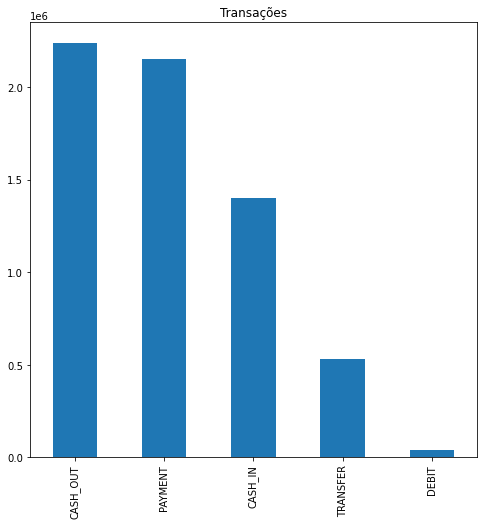

In [13]:
#Quantidade por tipo de transação

fig, ax = plt.subplots(figsize=(8, 8))

df.type.value_counts().plot(kind='bar', title="Transações", ax=ax)

plt.show()

In [14]:
#Valores numericos
df.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

### Criamos o mesmo grafico mas agora apenas com os valores das fraudes

In [15]:
#Criando o dataset com apenas as fraudes
fraud = df[df.isFraud == 1]

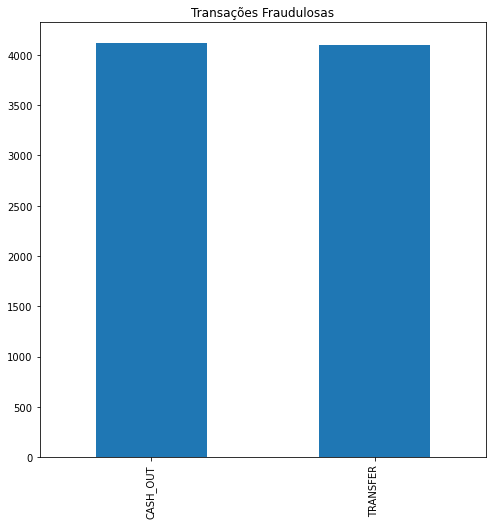

In [16]:
#Quantidade por tipo de transação
fig, ax = plt.subplots(figsize=(8, 8))

fraud.type.value_counts().plot(kind='bar', title="Transações Fraudulosas", ax=ax)

plt.show()

In [17]:
#Valores numericos
fraud.type.value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

# Normalizando os Dados

Deletaremos algumas colunas que não serão uteis para a analise

Realizaremos um on hot encoder na coluna Type para poder transformar os valores de texto em numeros

nameOrig/nameDest - não trabalharemos com os nomes pois eles não agregam tanto para o nosso modelo de classificação

In [18]:
#Criando um modelo com one hot encoder
aux = pd.get_dummies(df["type"])
final = pd.concat( [df, aux], axis=1)

In [19]:
final = final.drop(columns=["type", "nameOrig", "nameDest"])

In [20]:
#Cabeçalho DataFrame Final
final.head(10)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.00,160296.36,0.0,0.00,0,0,0,0,0,1,0
1,1,1864.28,21249.00,19384.72,0.0,0.00,0,0,0,0,0,1,0
2,1,181.00,181.00,0.00,0.0,0.00,1,0,0,0,0,0,1
3,1,181.00,181.00,0.00,21182.0,0.00,1,0,0,1,0,0,0
4,1,11668.14,41554.00,29885.86,0.0,0.00,0,0,0,0,0,1,0
5,1,7817.71,53860.00,46042.29,0.0,0.00,0,0,0,0,0,1,0
6,1,7107.77,183195.00,176087.23,0.0,0.00,0,0,0,0,0,1,0
7,1,7861.64,176087.23,168225.59,0.0,0.00,0,0,0,0,0,1,0
8,1,4024.36,2671.00,0.00,0.0,0.00,0,0,0,0,0,1,0
9,1,5337.77,41720.00,36382.23,41898.0,40348.79,0,0,0,0,1,0,0


# Criação de Modelos

In [ ]:
#Separando Dados e Labels
x = final.drop(columns=["isFraud", "isFlaggedFraud"])
y = final["isFraud"]

### Modelo 30% para teste

In [23]:
#Separando dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=6)

In [61]:
#Criando o modelo
regr3 = linear_model.LinearRegression()

In [62]:
#Treinando o modelo
regr3.fit(x_train, y_train)

LinearRegression()

In [63]:
#Fazendo predição
y_pred = regr3.predict(x_test)

In [64]:
print("Coeficiente: ", regr3.coef_)

Coeficiente:  [ 5.93391562e-06  9.38864996e-09  1.18943804e-07 -1.19039332e-07
  6.75537833e-09 -6.86783055e-09  1.49506372e-02 -4.95061679e-03
 -3.44824518e-03 -4.14412410e-03 -2.40765110e-03]


In [65]:
mean03 = mean_squared_error(y_test, y_pred)
print("Mean squared error: %.5f"%mean03)

Mean squared error: 0.00105


In [66]:
r203 = r2_score(y_test, y_pred)
print("R2: %.5f"%r203)

R2: 0.17342


### Modelo 20% para teste

In [30]:
#Separando dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=6)

In [31]:
#Criando o modelo
regr2 = linear_model.LinearRegression()

In [32]:
#Treinando o modelo
regr2.fit(x_train, y_train)

LinearRegression()

In [33]:
#Fazendo predição
y_pred = regr2.predict(x_test)

In [34]:
print("Coeficiente: ", regr2.coef_)

Coeficiente:  [ 5.93723509e-06  9.43862244e-09  1.19607229e-07 -1.19703468e-07
  6.79494638e-09 -6.91036994e-09  1.50295176e-02 -4.99707792e-03
 -3.47312154e-03 -4.17170516e-03 -2.38761300e-03]


In [35]:
mean02 = mean_squared_error(y_test, y_pred)
print("Mean squared error: %.5f"%mean02)

Mean squared error: 0.00105


In [36]:
r202 = r2_score(y_test, y_pred)
print("R2: %.5f"%r202)

R2: 0.17174


### Modelo 50% para teste

In [37]:
#Separando dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=6)

In [38]:
#Criando o modelo
regr5 = linear_model.LinearRegression()

In [39]:
#Treinando o modelo
regr5.fit(x_train, y_train)

LinearRegression()

In [40]:
#Fazendo predição
y_pred = regr5.predict(x_test)

In [41]:
print("Coeficiente: ", regr5.coef_)

Coeficiente:  [ 6.16289248e-06  9.24933082e-09  1.19604251e-07 -1.19703104e-07
  6.65870563e-09 -6.76564273e-09  1.50715537e-02 -4.99846074e-03
 -3.49667358e-03 -4.19228980e-03 -2.38412958e-03]


In [42]:
mean05 = mean_squared_error(y_test, y_pred)
print("Mean squared error: %.5f"%mean05)

Mean squared error: 0.00104


In [43]:
r205 = r2_score(y_test, y_pred)
print("R2: %.5f"%r205)

R2: 0.17705


## Resultados Modelos Lineares

In [44]:
print("Test Size 30%")
print("MSE: %.5f"%mean03)
print("R2: %.5f"%r203)

print("\nTest Size 20%")
print("MSE: %.5f"%mean02)
print("R2: %.5f"%r202)

print("\nTest Size 50%")
print("MSE: %.5f"%mean05)
print("R2: %.5f"%r205)

Test Size 30%
MSE: 0.00105
R2: 0.17342

Test Size 20%
MSE: 0.00105
R2: 0.17174

Test Size 50%
MSE: 0.00104
R2: 0.17705


# Modelo com Arvores de Decisão

In [45]:
#Separando dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=6)

In [67]:
#Criando a arvore
tree = DecisionTreeClassifier()
#Treinando a arvore
tree.fit(x_train, y_train)
#Fazendo a predição
y_pred_label = tree.predict(x_test)

In [68]:
print(metrics.classification_report(y_test, y_pred_label))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906348
           1       0.89      0.88      0.89      2438

    accuracy                           1.00   1908786
   macro avg       0.95      0.94      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786



In [69]:
print("Acuracia Arvore de Decisão: ", accuracy_score(y_test, y_pred_label))

Acuracia Arvore de Decisão:  0.9997113348484324


# Modelo com Floresta

In [70]:
#Separando dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=6)

In [71]:
#Criando a floresta
modelo_final = RandomForestClassifier(n_estimators=50)
#Treinando a floresta
modelo_final.fit(x_train, y_train)
#Fazendo a predição
y_pred_label2 = tree.predict(x_test)

In [72]:
print(metrics.classification_report(y_test, y_pred_label2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2541817
           1       0.92      0.91      0.91      3231

    accuracy                           1.00   2545048
   macro avg       0.96      0.95      0.96   2545048
weighted avg       1.00      1.00      1.00   2545048



In [73]:
print("Acuracia Floresta de decisão: ", accuracy_score(y_test, y_pred_label2))

Acuracia Floresta de decisão:  0.9997835011363243


# Avaliação

Testando varios tipos de modelagens e metricas, conseguimos perceber que a base de dados tem a capacidade de criação de modelos muito acertativos, com taxas de acuracias altas e metricas como R² bem precisas.

# Proximos passos

É possivel a criação de novos modelos de classifcação diferentes como o Naive Bayes ou MLP Classifier, também podemos modificar as arvores ou a floresta para conseguir um resultado ainda melhor.

# Referencias 

### DataBase problema Kaggle
https://www.kaggle.com/ealaxi/paysim1
    
Alguns comentarios de usuarios foram usados para ajudar com a analise da base de dados para a criação dos modelos.